## Exploratory data analysis

### Environment setup

In [1]:
! pip install -r requiriments.txt --quiet

In [2]:
import math
import sys
import numpy  as np  
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import r_regression, mutual_info_regression, f_classif
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, MultiLabelBinarizer
from sklearn.compose import make_column_transformer
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from adjustText import adjust_text

import warnings
warnings.filterwarnings('ignore')

In [3]:
# to load custom libraries
LIBRARY_PATH = "."
sys.path.append(LIBRARY_PATH)

# load custom libraries
from utilsPlots import get_indexes_from_list, get_elements_from_list
from utilsPlots import plot_bars, plot_density, plot_correlation_vs_mi, plot_estimator_feature_contquant, plot_estimator_feature_qualit_bi, na_plot
from utilsPlots import plot_anova_vs_mi

### Load data

In [4]:
# load data
airbnb_data = pd.read_csv("../data/airbnb-listings-extract.csv", delimiter = ';') # load data
print(f'Number of samples: {airbnb_data.shape[0]}\nNumber of features: {airbnb_data.shape[1]}')

Number of samples: 14780
Number of features: 89


In [5]:
# any duplicated sample?
dupl = sum(airbnb_data['ID'].duplicated())
print(f'Number of duplicated ID: {dupl}')

Number of duplicated ID: 0


In [6]:
# split train and test
df_train, df_test = train_test_split(airbnb_data, test_size = 0.3, shuffle = True, random_state = 0)
print(f'Samples in train dataset: {df_train.shape[0]}')
print(f'Samples in test dataset: {df_test.shape[0]}')

Samples in train dataset: 10346
Samples in test dataset: 4434


### Feature analysis

The goal of the analysis is to predict accommodation prices based on available property data. Therefore, during variable filtering, only features related to the accommodation's characteristics (amenities, location, etc.) will be retained, while all data related to reviews, availability, or pricing will be removed.

This would apply, for example, when a client has a property with specific features and location, and wants to know at what price to offer accommodation.

#### First stage of data cleaning

In [7]:
## all columns
print(f'Number of features: {df_train.shape[1]}\n')
print(', '.join(df_train.columns.tolist()))

Number of features: 89

ID, Listing Url, Scrape ID, Last Scraped, Name, Summary, Space, Description, Experiences Offered, Neighborhood Overview, Notes, Transit, Access, Interaction, House Rules, Thumbnail Url, Medium Url, Picture Url, XL Picture Url, Host ID, Host URL, Host Name, Host Since, Host Location, Host About, Host Response Time, Host Response Rate, Host Acceptance Rate, Host Thumbnail Url, Host Picture Url, Host Neighbourhood, Host Listings Count, Host Total Listings Count, Host Verifications, Street, Neighbourhood, Neighbourhood Cleansed, Neighbourhood Group Cleansed, City, State, Zipcode, Market, Smart Location, Country Code, Country, Latitude, Longitude, Property Type, Room Type, Accommodates, Bathrooms, Bedrooms, Beds, Bed Type, Amenities, Square Feet, Price, Weekly Price, Monthly Price, Security Deposit, Cleaning Fee, Guests Included, Extra People, Minimum Nights, Maximum Nights, Calendar Updated, Has Availability, Availability 30, Availability 60, Availability 90, Availa

In [8]:
df_train.shape

(10346, 89)

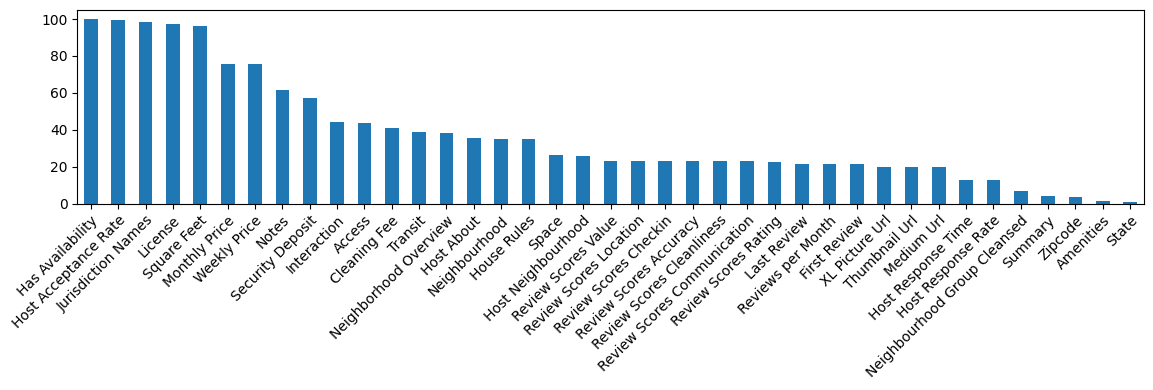

In [9]:
# percentage of NA values in each column
na_plot(df_train)

Variables with more than 70% of their values as NA are discarded. There is not enough information for imputation.

In [10]:
# feature to be dropped (PREPROC)
features_na_drop = ['Has Availability', 'Host Acceptance Rate', 'Jurisdiction Names', 'License', 'Square Feet', 'Monthly Price', 'Weekly Price']

In [11]:
# numeric/non numeric columns 
df_types = df_train.dtypes
columns_non_num = df_types[df_types == 'object'].index
columns_num = df_types[df_types != 'object'].index
print(f'Number of non-numeric features: {len(columns_non_num)}\n')
print(', '.join(columns_non_num))
print(f'\nNumber of numeric features: {len(columns_num)}\n')
print(', '.join(columns_num))

Number of non-numeric features: 53

Listing Url, Last Scraped, Name, Summary, Space, Description, Experiences Offered, Neighborhood Overview, Notes, Transit, Access, Interaction, House Rules, Thumbnail Url, Medium Url, Picture Url, XL Picture Url, Host URL, Host Name, Host Since, Host Location, Host About, Host Response Time, Host Acceptance Rate, Host Thumbnail Url, Host Picture Url, Host Neighbourhood, Host Verifications, Street, Neighbourhood, Neighbourhood Cleansed, Neighbourhood Group Cleansed, City, State, Zipcode, Market, Smart Location, Country Code, Country, Property Type, Room Type, Bed Type, Amenities, Calendar Updated, Has Availability, Calendar last Scraped, First Review, Last Review, License, Jurisdiction Names, Cancellation Policy, Geolocation, Features

Number of numeric features: 36

ID, Scrape ID, Host ID, Host Response Rate, Host Listings Count, Host Total Listings Count, Latitude, Longitude, Accommodates, Bathrooms, Bedrooms, Beds, Square Feet, Price, Weekly Price, 

In [12]:
# overview non-numeric columns that contain 'url', 'scraped', 'name', 'calendar' or 'host' strings
columns_sel = list(filter(lambda x: any(s in x.lower() for s in ['url', 'scraped', 'name', 'calendar', 'host']), columns_non_num))
print(f'Number of selected columns: {len(columns_sel)}')
df_train[columns_sel].head().T

Number of selected columns: 21


,4706,6422,4339,1666,4578
Listing Url,https://www.airbnb.com/rooms/2156319,https://www.airbnb.com/rooms/3377153,https://www.airbnb.com/rooms/14800635,https://www.airbnb.com/rooms/11185674,https://www.airbnb.com/rooms/18092171
Last Scraped,2017-04-08,2017-04-08,2017-04-08,2017-04-08,2017-04-08
Name,GRANT VII Plaza Mayor,Nice flat in Plaza Mayor (lift),* ROOM double Barrio Salamanca *,cheap apartment in Madrid city cent,"ACOGEDOR APARTAMENTO EN MADRID, CALLE MANZANARES"
Thumbnail Url,NaN,https://a0.muscache.com/im/pictures/47295744/3...,https://a0.muscache.com/im/pictures/069c59b5-c...,https://a0.muscache.com/im/pictures/c2fea8e5-0...,https://a0.muscache.com/im/pictures/144dbcd9-c...
Medium Url,NaN,https://a0.muscache.com/im/pictures/47295744/3...,https://a0.muscache.com/im/pictures/069c59b5-c...,https://a0.muscache.com/im/pictures/c2fea8e5-0...,https://a0.muscache.com/im/pictures/144dbcd9-c...
Picture Url,https://public.opendatasoft.com/api/v2/catalog...,https://public.opendatasoft.com/api/v2/catalog...,https://public.opendatasoft.com/api/v2/catalog...,https://public.opendatasoft.com/api/v2/catalog...,https://public.opendatasoft.com/api/v2/catalog...
XL Picture Url,NaN,https://a0.muscache.com/im/pictures/47295744/3...,https://a0.muscache.com/im/pictures/069c59b5-c...,https://a0.muscache.com/im/pictures/c2fea8e5-0...,https://a0.muscache.com/im/pictures/144dbcd9-c...
Host URL,https://www.airbnb.com/users/show/1650712,https://www.airbnb.com/users/show/17037651,https://www.airbnb.com/users/show/88187861,https://www.airbnb.com/users/show/32747079,https://www.airbnb.com/users/show/123220020
Host Name,Ximena,Miguel,Adan,Cristian,Luz Adriana
Host Since,2012-01-25,2014-06-20,2016-08-05,2015-05-06,2017-03-29


In [13]:
# overview non_numeric columns not containing 'url', 'scraped', 'name', 'calendar' or 'host' strings
columns_sel = list(filter(lambda x: not(any(s in x.lower() for s in ['url', 'scraped', 'name', 'calendar', 'host'])), columns_non_num))
print(f'Number of selected columns: {len(columns_sel)}')
df_train[columns_sel].head().T

Number of selected columns: 32


,4706,6422,4339,1666,4578
Summary,NaN,"Flat is in the centre town, really close to Pl...","Private room for two persons has a double bed,...","Cheap apartment, next to Madrid rio, just four...","Acogedor apartamento, para parejas y/o familia."
Space,Beautiful and charming apartment recently deco...,You cannot find a better location to stay in M...,It is a penthouse located in the salamanca dis...,NaN,NaN
Description,Beautiful and charming apartment recently deco...,"Flat is in the centre town, really close to Pl...","Private room for two persons has a double bed,...","Cheap apartment, next to Madrid rio, just four...","Acogedor apartamento, para parejas y/o familia."
Experiences Offered,none,none,none,none,none
Neighborhood Overview,NaN,"It´s really cool, with a lot of new business (...",The District of Salamanca is one of the 21 dis...,NaN,NaN
Notes,NaN,"Apartment has wifi, lift, wash-machine and air...",It is important to know that the floor is shar...,NaN,NaN
Transit,NaN,"The best way is walking, since in Madrid all a...",Metro stations: * Lista 70 metres (line 4) fr...,NaN,NaN
Access,NaN,"The kitchen is available with oil, sugar, coff...","The common areas are completely free to use, l...",NaN,NaN
Interaction,NaN,You can call me if you have any doubt or if yo...,I will always be on the lookout for what you c...,NaN,NaN
House Rules,Rest hours: Monday to Friday from (phone numbe...,Just enjoy Madrid! You are in your home in Sp...,***Lo más importante pasarlo bien y que se si...,NO PARTY.,- No se admiten mascotas - No se admiten fiest...


Variables are reviewed and an initial filtering of variables with no useful information is performed.

In [14]:
# features to be kept (PREPROC)
features_non_num_keep = ['Host Location', 'Host Neighbourhood', 'Experiences Offered', 'Neighbourhood', 'Neighbourhood Cleansed', 
                         'Neighbourhood Group Cleansed', 'City', 'State', 'Market', 'Smart Location', 'Country Code', 'Country', 
                         'Property Type', 'Room Type', 'Bed Type', 'Amenities', 'License', 'Cancellation Policy', 'Geolocation']

In [15]:
# overview numeric columns
print(f'Number of selected columns: {len(columns_num)}')
df_train[columns_num].head().T

Number of selected columns: 36


,4706,6422,4339,1666,4578
ID,2.156319e+06,3.377153e+06,1.480064e+07,1.118567e+07,1.809217e+07
Scrape ID,2.017041e+13,2.017041e+13,2.017041e+13,2.017041e+13,2.017041e+13
Host ID,1.650712e+06,1.703765e+07,8.818786e+07,3.274708e+07,1.232200e+08
Host Response Rate,1.000000e+02,1.000000e+02,1.000000e+02,NaN,NaN
Host Listings Count,4.000000e+01,1.000000e+00,3.000000e+00,1.000000e+00,4.000000e+00
Host Total Listings Count,4.000000e+01,1.000000e+00,3.000000e+00,1.000000e+00,4.000000e+00
Latitude,4.041542e+01,4.041113e+01,4.042805e+01,4.039645e+01,4.041345e+01
Longitude,-3.707123e+00,-3.707258e+00,-3.676042e+00,-3.714100e+00,-3.718438e+00
Accommodates,4.000000e+00,4.000000e+00,2.000000e+00,6.000000e+00,3.000000e+00
Bathrooms,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


These features will be dropped because they do not have relevant information for a new accommodation that it is going to be offered for the first time

In [16]:
features_num_drop = ['ID', 'Scrape ID', 'Host ID', 'Host Response Rate', 'Host Listings Count', 'Host Total Listings Count', 
                     'Geolocation', 'Weekly Price', 'Monthly Price', 'Security Deposit', 
                     'Cleaning Fee','Extra People','Minimum Nights', 'Maximum Nights', 'Availability 30', 'Availability 60', 'Availability 90', 
                     'Availability 365', 'Number of Reviews', 'Review Scores Rating', 'Review Scores Accuracy', 'Review Scores Cleanliness', 
                     'Review Scores Checkin', 'Review Scores Communication', 'Review Scores Location', 'Review Scores Value', 
                     'Calculated host listings count', 'Reviews per Month']

In [17]:
# result from first filtering step (PREPROC)
features_non_num_drop = [feature for feature in columns_non_num if not(feature in features_non_num_keep)]
features_clean1_drop = features_non_num_drop + features_num_drop + features_na_drop
df_train_clean = df_train.drop(features_clean1_drop, axis = 1)
print(f'Number of features: {df_train_clean.shape[1]}\n')
print(', '.join(df_train_clean.columns.tolist()))

Number of features: 25

Experiences Offered, Host Location, Host Neighbourhood, Neighbourhood, Neighbourhood Cleansed, Neighbourhood Group Cleansed, City, State, Market, Smart Location, Country Code, Country, Latitude, Longitude, Property Type, Room Type, Accommodates, Bathrooms, Bedrooms, Beds, Bed Type, Amenities, Price, Guests Included, Cancellation Policy


In [18]:
df_train_clean.head().T

,4706,6422,4339,1666,4578
Experiences Offered,none,none,none,none,none
Host Location,"Madrid, Madrid, Spain","Madrid, Community of Madrid, Spain","Madrid, Community of Madrid, Spain","Madrid, Community of Madrid, Spain",ES
Host Neighbourhood,La Latina,La Latina,Goya,Carabanchel,Sol
Neighbourhood,Sol,La Latina,NaN,Carabanchel,Imperial
Neighbourhood Cleansed,Sol,Embajadores,Goya,Comillas,Imperial
Neighbourhood Group Cleansed,Centro,Centro,Salamanca,Carabanchel,Arganzuela
City,Madrid,Madrid,Madrid,Madrid,Madrid
State,Community of Madrid,Comunidad de Madrid,Comunidad de Madrid,Comunidad de Madrid,Comunidad de Madrid
Market,Madrid,Madrid,Madrid,Madrid,Madrid
Smart Location,"Madrid, Spain","Madrid, Spain","Madrid, Spain","Madrid, Spain","Madrid, Spain"


#### Second stage of cleaning data

In this stage some features will be checked in more detail

**Features related to location**

In [19]:
features_location = ['Host Location', 'City', 'State','Market', 'Smart Location', 'Country Code', 'Country']
df_train_clean[features_location]

,Host Location,City,State,Market,Smart Location,Country Code,Country
4706,"Madrid, Madrid, Spain",Madrid,Community of Madrid,Madrid,"Madrid, Spain",ES,Spain
6422,"Madrid, Community of Madrid, Spain",Madrid,Comunidad de Madrid,Madrid,"Madrid, Spain",ES,Spain
4339,"Madrid, Community of Madrid, Spain",Madrid,Comunidad de Madrid,Madrid,"Madrid, Spain",ES,Spain
1666,"Madrid, Community of Madrid, Spain",Madrid,Comunidad de Madrid,Madrid,"Madrid, Spain",ES,Spain
4578,ES,Madrid,Comunidad de Madrid,Madrid,"Madrid, Spain",ES,Spain
...,...,...,...,...,...,...,...
13123,"Madrid, Community of Madrid, Spain",Madrid,Comunidad de Madrid,Madrid,"Madrid, Spain",ES,Spain
3264,ES,Madrid,Comunidad de Madrid,Madrid,"Madrid, Spain",ES,Spain
9845,"Madrid, Community of Madrid, Spain",Madrid,Comunidad de Madrid,Madrid,"Madrid, Spain",ES,Spain
10799,"Madrid, Community of Madrid, Spain",Madrid,Comunidad de Madrid,Madrid,"Madrid, Spain",ES,Spain


These variables contain highly redundant information

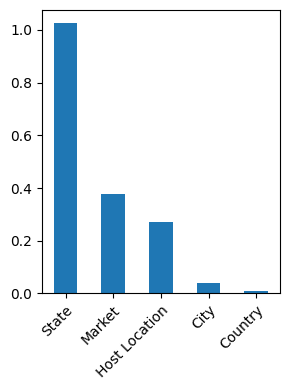

In [20]:
# plot NA for these features
na_plot(df_train_clean[features_location], threshold=0)

Only two features contains value for all samples 'Smart Location' and 'Country Code'. The others features related to location are removed.

In [21]:
print(f'Number of levels: {df_train_clean["Smart Location"].value_counts().shape[0]}')
df_train_clean['Smart Location'].value_counts().head(8)

Number of levels: 217


Smart Location
Madrid, Spain             9243
Barcelona, Spain           209
London, United Kingdom      97
Paris, France               70
马德里, Spain                  42
Palma, Spain                37
Alcúdia, Spain              29
Berlin, Germany             29
Name: count, dtype: int64

In [22]:
print(f'Number of levels: {df_train_clean["Country Code"].value_counts().shape[0]}')
df_train_clean['Country Code'].value_counts().head(8)

Number of levels: 18


Country Code
ES    9817
GB     118
US     115
FR      72
IT      51
AU      33
DE      30
IE      23
Name: count, dtype: int64

In [23]:
# features to be dropped (PREPROC)
features_location_drop = ['Host Location', 'City', 'State','Market', 'Country']

**Features related to neighbourhood**

This variable is only meaningful for the set of accommodations in Madrid, as the number of accommodations for other cities is very low.

In [24]:
df_train_madrid = df_train_clean[df_train_clean['Smart Location'] == 'Madrid, Spain']
df_train_madrid['Neighb. G. Clean'] = df_train_madrid['Neighbourhood Group Cleansed']
df_train_madrid['Neighb. Clean'] = df_train_madrid['Neighbourhood Cleansed']
df_train_madrid['Neighb.'] = df_train_madrid['Neighbourhood']
df_train_madrid['Host Neighb.'] = df_train_madrid['Host Neighbourhood']
features_neighbour = ['Host Neighb.', 'Neighb.', 'Neighb. Clean', 'Neighb. G. Clean']
df_train_madrid[features_neighbour]

,Host Neighb.,Neighb.,Neighb. Clean,Neighb. G. Clean
4706,La Latina,Sol,Sol,Centro
6422,La Latina,La Latina,Embajadores,Centro
4339,Goya,NaN,Goya,Salamanca
1666,Carabanchel,Carabanchel,Comillas,Carabanchel
4578,Sol,Imperial,Imperial,Arganzuela
...,...,...,...,...
13123,Argüelles,Argüelles,Argüelles,Moncloa - Aravaca
3264,Aluche,Aluche,Aluche,Latina
9845,NaN,NaN,Palacio,Centro
10799,La Latina,La Latina,Palacio,Centro


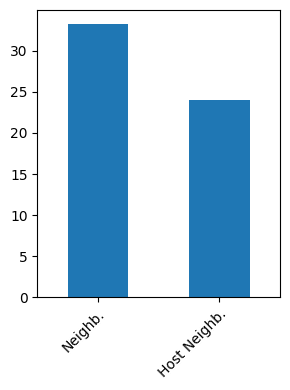

In [25]:
# plot NA for these features
na_plot(df_train_madrid[features_neighbour], threshold=0)

In [26]:
print(f'Number of levels: {df_train_madrid["Neighbourhood Cleansed"].value_counts().shape[0]}')
df_train_madrid['Neighbourhood Cleansed'].value_counts()

Number of levels: 123


Neighbourhood Cleansed
Embajadores      1286
Universidad       923
Palacio           785
Sol               675
Justicia          563
                 ... 
Fuentelareina       3
Orcasitas           2
Hellín              2
El Goloso           2
El Plantío          2
Name: count, Length: 123, dtype: int64

In [27]:
print(f'Number of levels: {df_train_madrid["Neighbourhood Group Cleansed"].value_counts().shape[0]}')
df_train_madrid['Neighbourhood Group Cleansed'].value_counts()

Number of levels: 21


Neighbourhood Group Cleansed
Centro                   4754
Chamberí                  673
Salamanca                 621
Arganzuela                558
Tetuán                    313
Moncloa - Aravaca         297
Retiro                    294
Latina                    260
Chamartín                 252
Carabanchel               248
Ciudad Lineal             207
Puente de Vallecas        137
Hortaleza                 120
Usera                     103
Fuencarral - El Pardo     102
San Blas - Canillejas      77
Barajas                    57
Villaverde                 56
Moratalaz                  55
Villa de Vallecas          36
Vicálvaro                  23
Name: count, dtype: int64

Features related to neighborhood are redundant. Only 'Neighbourhood Group Cleaned' is retained because it contains no NA values and serves as a simplified version of 'Neighbourhood Cleaned', with fewer categorical levels.

In [28]:
features_neighbour_drop = ['Host Neighbourhood', 'Neighbourhood', 'Neighbourhood Cleansed']

**Experiences Offered feature**

In [29]:
df_train_clean['Experiences Offered'].value_counts()

Experiences Offered
none        10334
business        6
social          3
family          2
romantic        1
Name: count, dtype: int64

It is a highly imbalanced variable across its categories, so it was discarded.

Remove the selected features for location, neighbourhood and 'Experiences Offered'

In [30]:
# remove features (PREPROC)
features_clean2_drop = features_location_drop + features_neighbour_drop + ['Experiences Offered']
df_train_clean2 = df_train_clean.drop(features_clean2_drop, axis = 1)
df_train_clean2['Neighbour'] = df_train_clean2['Neighbourhood Group Cleansed']
df_train_clean2 = df_train_clean2.drop(['Neighbourhood Group Cleansed'], axis = 1)
print(f'Number of features: {df_train_clean2.shape[1]}\n')
print(list(df_train_clean2.columns))
df_train_clean2.head().T

Number of features: 16

['Smart Location', 'Country Code', 'Latitude', 'Longitude', 'Property Type', 'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Bed Type', 'Amenities', 'Price', 'Guests Included', 'Cancellation Policy', 'Neighbour']


,4706,6422,4339,1666,4578
Smart Location,"Madrid, Spain","Madrid, Spain","Madrid, Spain","Madrid, Spain","Madrid, Spain"
Country Code,ES,ES,ES,ES,ES
Latitude,40.415418,40.411131,40.42805,40.396449,40.413447
Longitude,-3.707123,-3.707258,-3.676042,-3.7141,-3.718438
Property Type,Apartment,Apartment,Apartment,Apartment,Apartment
Room Type,Entire home/apt,Entire home/apt,Private room,Entire home/apt,Entire home/apt
Accommodates,4,4,2,6,3
Bathrooms,1.0,1.0,1.0,1.0,1.0
Bedrooms,1.0,1.0,1.0,3.0,2.0
Beds,2.0,2.0,1.0,4.0,2.0


#### Feature visualization

The remaining features will be examined more thoroughly.

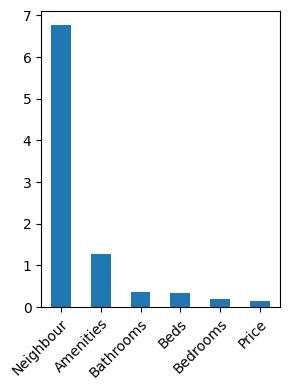

In [31]:
# features with NA values
na_plot(df_train_clean2, threshold=0)

In [32]:
features_class = {'qualitative': ['Property Type', 'Room Type', 'Bed Type', 'Cancellation Policy', 'Country Code'],
            'discreteQuantitative': ['Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Guests Included'],
            'contQuantitative': ['Price', 'Latitude', 'Longitude']}

**Discrete quantitative**

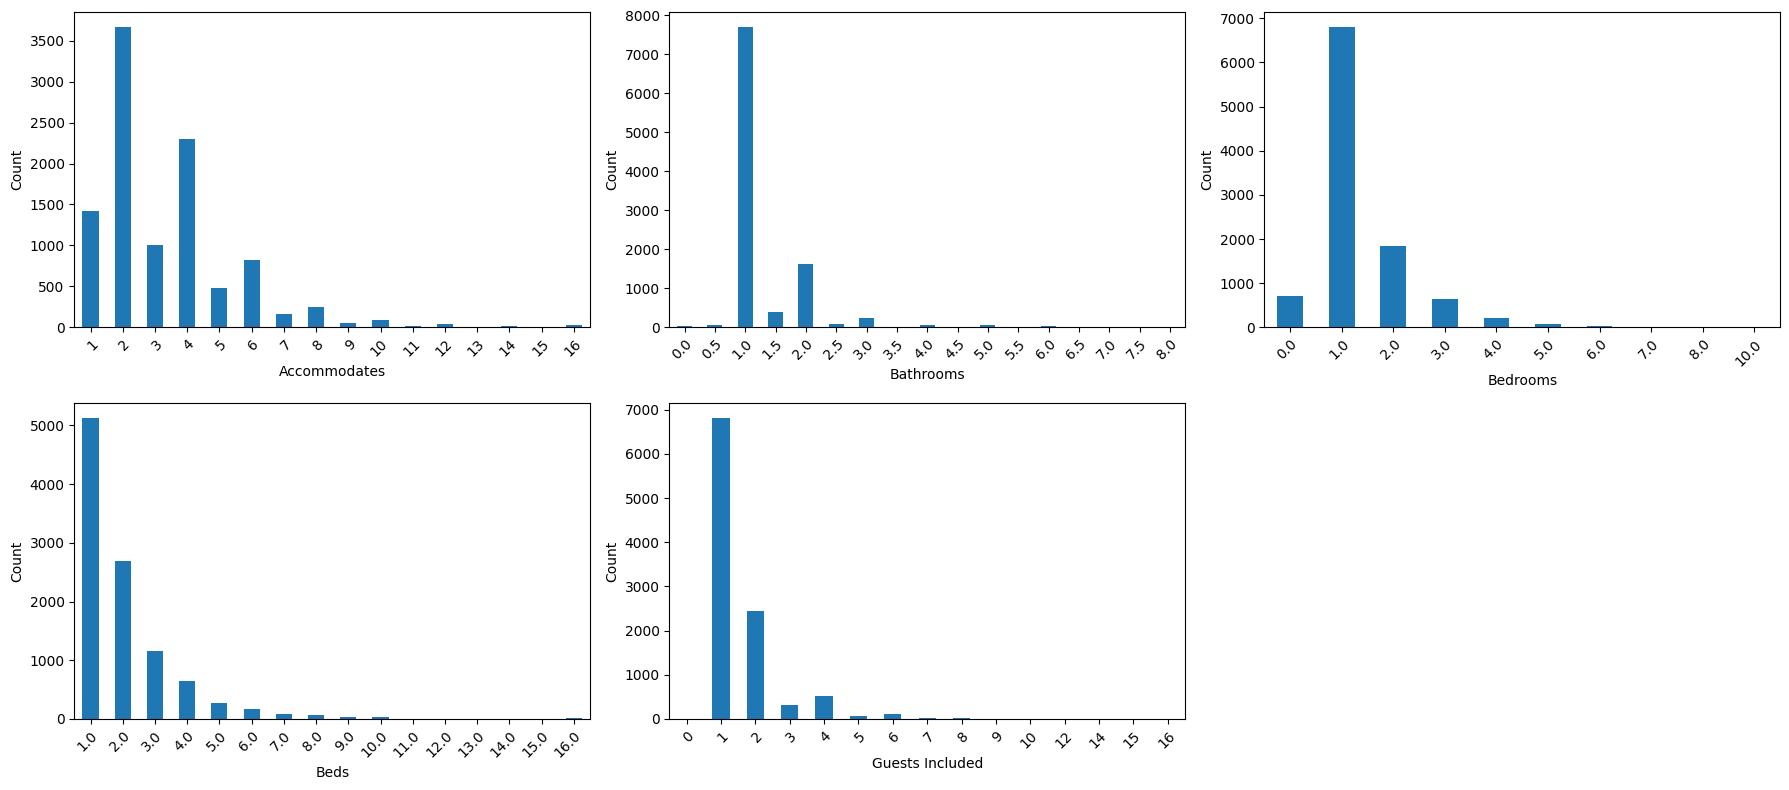

In [33]:
plot_bars(df_train_clean2, features_class['discreteQuantitative'], 2, 3, sort = False)

In [34]:
guest_included_zero = sum(df_train_clean2['Guests Included'] == 0)
print(f'Number of samples with zero in feature Guest Included: {guest_included_zero}')
df_train_clean2[df_train_clean2['Guests Included'] == 0]

Number of samples with zero in feature Guest Included: 1


,Smart Location,Country Code,Latitude,Longitude,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Price,Guests Included,Cancellation Policy,Neighbour
2905,"Manchester, United Kingdom",GB,53.451453,-2.26542,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"Internet,Wireless Internet,Kitchen,Free Parkin...",30.0,0,moderate,NaN


**Qualitative**

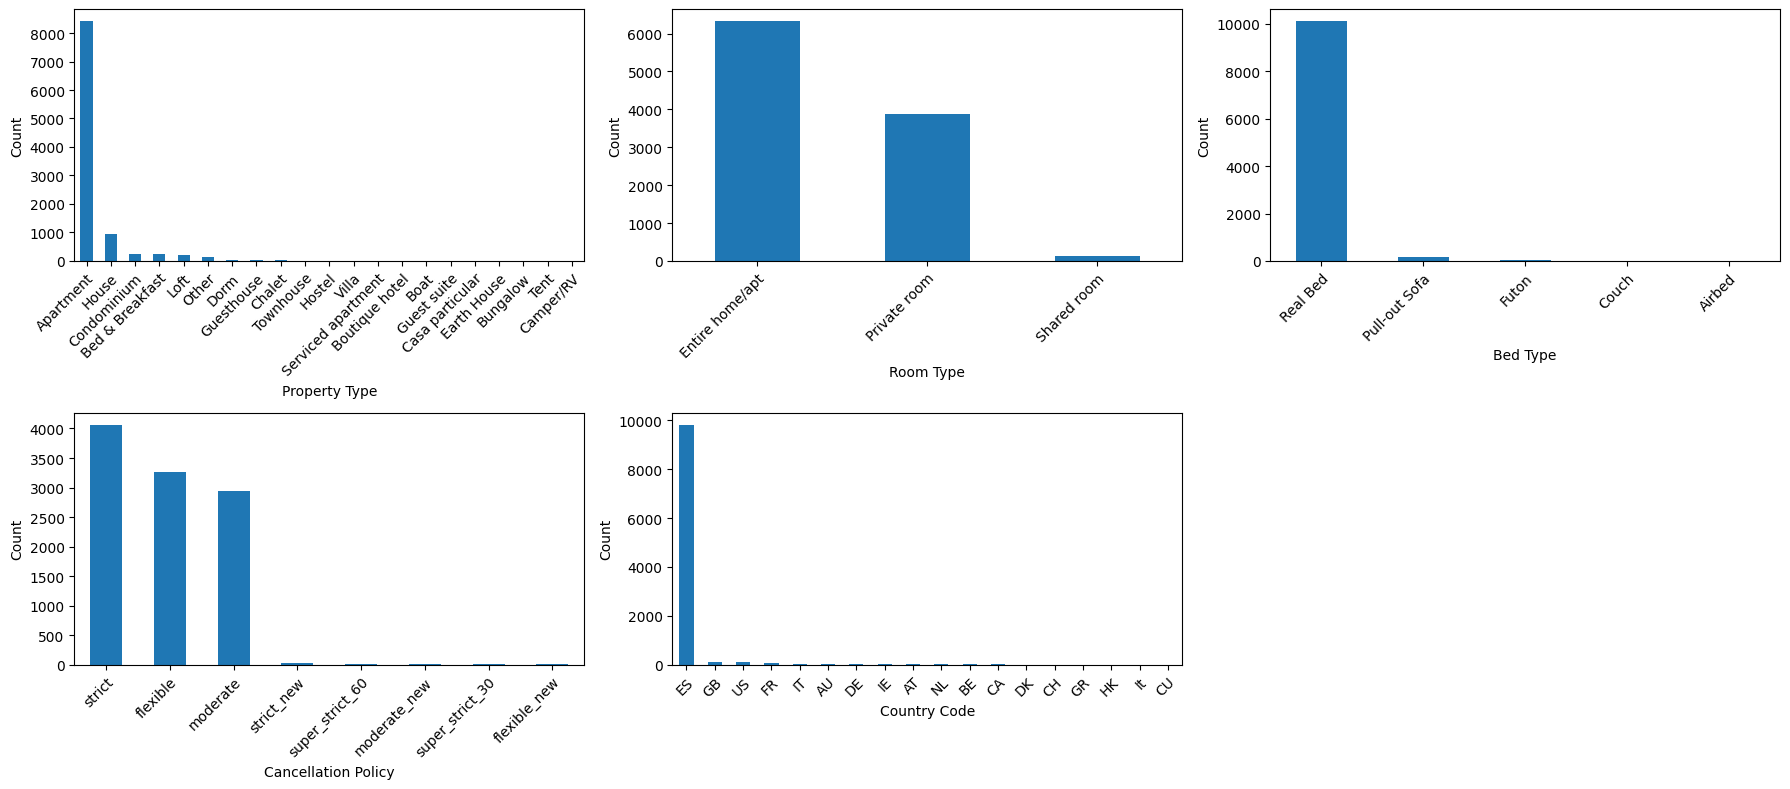

In [35]:
plot_bars(df_train_clean2, features_class['qualitative'], 2, 3, sort = True)

**Continuous quantitative**

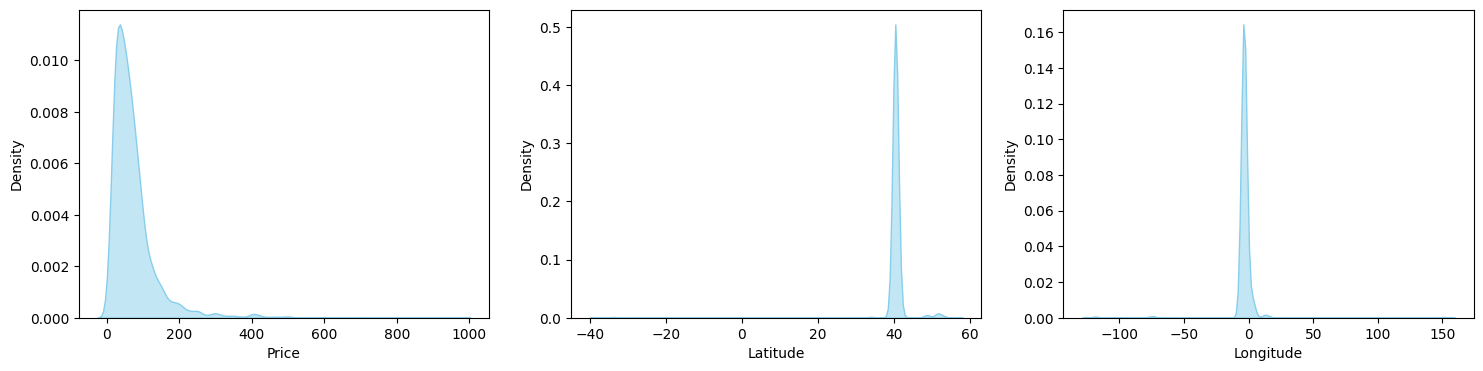

In [36]:
plot_density(df_train_clean2, features_class['contQuantitative'], 1, 3)

**Amenities feature**

Amenities to remove:
['translation missing: en.hosting_amenity_50', 'translation missing: en.hosting_amenity_49']
Number of unique amenities: 79


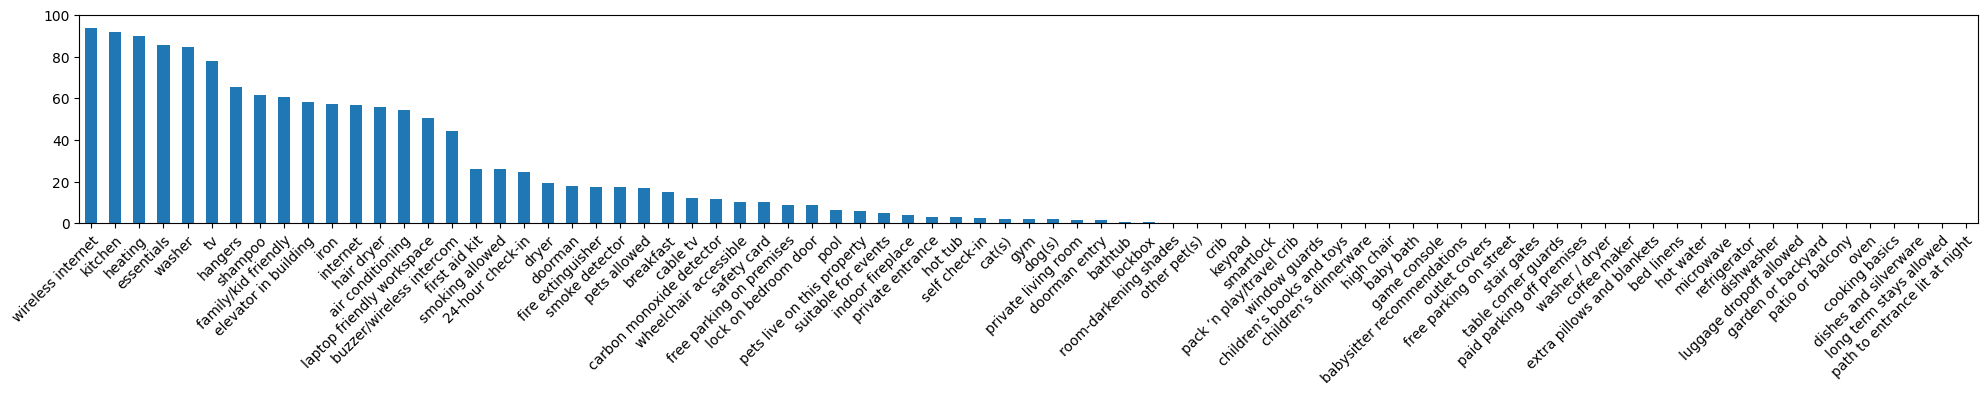

In [37]:
amenities = pd.Series(sum(df_train_clean['Amenities'].dropna().str.lower().str.split(',').tolist(), [])).value_counts()
amenities_drop = list(filter(lambda x: 'translation' in x, amenities.index))
print('Amenities to remove:')
print(amenities_drop)
amenities = amenities[list(map(lambda x: 'translation' not in x, amenities.index))]
amenities = amenities/df_train_clean.shape[0] * 100
print(f'Number of unique amenities: {len(amenities)}')
plt.figure(figsize=(20,4))
ax = amenities.sort_values(ascending=False).plot.bar()
ax.set_xticklabels(ax.get_xticklabels(), 
                   rotation=45,
                   ha='right',  # Horizontal alignment
                   rotation_mode='anchor')
plt.tight_layout()
plt.ylim(0,100)
plt.show()

**Smart Location**

This feature will be removed. Most of the accommodations are located in Madrid.

In [38]:
total_locations = len(set(df_train_clean2['Smart Location'].tolist()))
locations_more_two = sum(df_train_clean2['Smart Location'].value_counts() > 2)
print(f'Number of unique locations: {total_locations}')
print(f'Number of locations with more than two samples: {locations_more_two}')

Number of unique locations: 217
Number of locations with more than two samples: 64


**Neighbourhood**

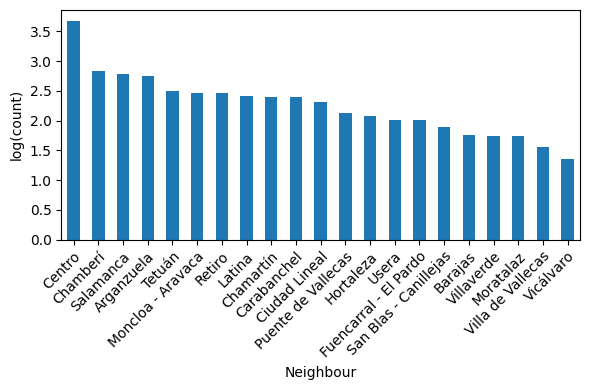

In [39]:
df_train_madrid = df_train_clean2[df_train_clean2['Smart Location'] == 'Madrid, Spain']
plot_bars(df_train_madrid, ['Neighbour'], 1, 1, sort = True, log = True)

#### NA handling

In [40]:
# NA handling (PREPROC)
# Remove samples without info about Price
df_train_imp = df_train_clean2[~(df_train_clean2['Price'].isna())]
# impute na values in Bedrooms
df_train_imp['Bedrooms'] = df_train_imp['Bedrooms'].fillna(0)
# impute na values in Bathrooms
df_train_imp['Bathrooms'] = df_train_imp['Bathrooms'].fillna(0)
# impute Beds with value from Bedrooms
df_train_imp['Beds'] = df_train_imp['Beds'].fillna(df_train_imp['Bedrooms'])
# impute na values in Amenities
df_train_imp['Amenities'] = df_train_imp['Amenities'].fillna('No services')
# impute zero values in Guests Included by Beds
df_train_imp['Guests Included'] = df_train_imp['Guests Included'].where(df_train_imp['Guests Included'] != 0, df_train_imp['Beds'])

#### Feature importance analysis

**Quantitative features vs Target**

In this analysis, qualitative variables that required target encoding will also be considered, for example, Property Type, Room Type, Bed Type and Cancellation Policy

In [41]:
# encode features using TargetEncoder
qualit_TE = ['Property Type','Room Type', 'Bed Type', 'Cancellation Policy', 'Country Code']
qualit_TE_new = list(map(lambda x: x + ' TE', qualit_TE))
X = df_train_imp[qualit_TE].values
y = df_train_imp['Price']

encoder = TargetEncoder(target_type="continuous", smooth = "auto")
encoder.fit(X, y)
df_train_imp[qualit_TE_new] = encoder.transform(X)

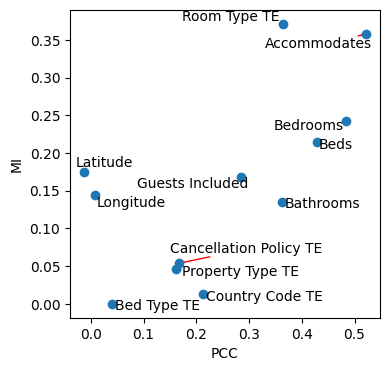

In [42]:
# plot scatter plot correlation vs MI
quant = features_class['discreteQuantitative'] + features_class['contQuantitative'] + qualit_TE_new
quant.remove('Price')

X = df_train_imp[quant]
y = df_train_imp['Price']

r_test = r_regression(X, y).tolist()
mi = mutual_info_regression(X, y).tolist()

feature_stats = {'feature': quant, 'pcc': r_test, 'mi': mi}

plot_correlation_vs_mi(feature_stats)

**Qualitative features vs Target**

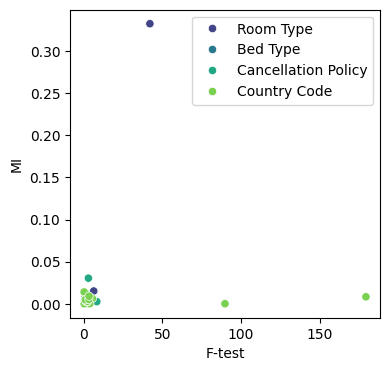

In [43]:
# plot scatter plot ANOVA F-test vs MI (only features with less than 10 levels)
qualit = features_class['qualitative'].copy()
qualit.remove('Property Type')

X = df_train_imp[qualit]
y = df_train_imp['Price']

# one-Hot Encoding
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Avoid dummy trap
X_encoded = encoder.fit(X)
X_encoded = encoder.transform(X)
feature_names = encoder.get_feature_names_out(input_features=X.columns)

# convert back to DataFrame for readability
X_encoded_df = pd.DataFrame(X_encoded, columns=feature_names)

# mutual Information (non-linear relationships)
mi = mutual_info_regression(X_encoded_df, y, random_state=42).tolist()

# ANOVA F-test (linear relationships)
f_scores, p_values = f_classif(X_encoded_df, y)

features = list(map(lambda x: x.split('_')[0],feature_names.tolist()))
feature_stats = {'feature': features, 'ftest': f_scores.tolist(), 'mi': mi}
plot_anova_vs_mi(feature_stats)

**Amenities feature**

In [44]:
# One hot encoder amenities
df_train_imp['AmenitiesStr'] = df_train_imp['Amenities'].str.lower().str.split(',').tolist()

# Initialize and fit the encoder
mlb = MultiLabelBinarizer()
mlb.fit(df_train_imp['AmenitiesStr'])
encoded = mlb.transform(df_train_imp['AmenitiesStr'])

# Convert to DataFrame with proper column names
df_amenities = pd.DataFrame(encoded, columns=mlb.classes_)
df_amenities.index = df_train_imp.index
df_amenities.drop(amenities_drop,axis=1)
amenities = [col for col in mlb.classes_ if col not in amenities_drop]

Number of selected amenities: 15
['dryer', 'indoor fireplace', 'no services', 'air conditioning', 'cable tv', 'family/kid friendly', 'pool', 'tv', 'free parking on premises', 'hot tub', 'lock on bedroom door', 'pets live on this property', 'wireless internet', 'suitable for events', 'cat(s)']


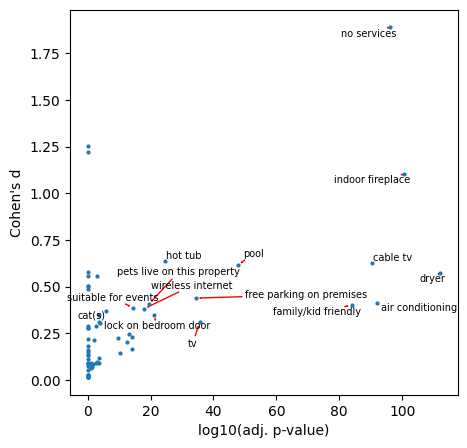

In [45]:
# calculate t-test and effect size
df = pd.concat([df_train_imp, df_amenities], axis = 1)

# initialize results storage
results = []

# loop through each binary feature
for col in amenities:
    # Group target values by feature levels
    group1 = df[df[col] == df[col].unique()[0]]['Price']  # First category (e.g., "Yes")
    group2 = df[df[col] == df[col].unique()[1]]['Price']  # Second category (e.g., "No")
    
    # perform t-test
    t_stat, p_value = ttest_ind(group1, group2)
    
    # calculate effect size (Cohen's d)
    n1, n2 = len(group1), len(group2)
    pooled_std = ((n1-1)*group1.std()**2 + (n2-1)*group2.std()**2) / (n1 + n2 - 2)
    cohen_d = abs(group1.mean() - group2.mean()) / pooled_std**0.5
    
    results.append({
        'Feature': col,
        'T-statistic': t_stat,
        'p-value': p_value,
        'Cohen_d': cohen_d,
        'Mean_diff': group1.mean() - group2.mean()
    })

# to DataFrame
results_df = pd.DataFrame(results).sort_values('p-value')

# apply correction to p-values
rejected, adj_pvals, _, _ = multipletests(
    results_df['p-value'], 
    alpha=0.05, 
    method='bonferroni'
)
results_df['adj_p-value'] = adj_pvals
results_df['logpvalue'] = np.log10(adj_pvals) * -1

# selected amenities
amenities_sel = results_df[(results_df['logpvalue'] > 5) & (results_df['Cohen_d'] > 0.25)]['Feature'].tolist()
print(f'Number of selected amenities: {len(amenities_sel)}')
print(amenities_sel)
# plot adj_p-value vs Cohen_d
features = {'feature': amenities, 'logpval': results_df['logpvalue'], 'cohend': results_df['Cohen_d']}
plt.figure(figsize=(5, 5))
plt.plot(features['logpval'], features['cohend'],'o', markersize=2)
plt.xlabel('log10(adj. p-value)')
plt.ylabel("Cohen's d")
texts = [plt.text(
    features['logpval'][i], features['cohend'][i], features['feature'][i], ha='center', va='center', fontsize=7) 
         for i in range(len(features['feature'])) if ((features['logpval'][i] > 5) & (features['cohend'][i] > 0.25))]
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
plt.show()

In [46]:
df_train_madrid = df_train_imp[df_train_imp['Smart Location'] == 'Madrid, Spain']

X = df_train_madrid[['Neighbour']].values
y = df_train_madrid['Price']

encoder = TargetEncoder(target_type="continuous", smooth = "auto")
encoder.fit(X, y)
df_train_madrid['Neighbour_TE'] = encoder.transform(X)

X = df_train_madrid[['Neighbour_TE']].values
y = df_train_madrid['Price']

r_test = float(r_regression(X, y))
mi = float(mutual_info_regression(X, y))
print(f'PCC: {r_test}')
print(f'Mutual information: {mi}')

PCC: 0.24618057984149153
Mutual information: 0.09603266129083732


In [47]:
features_sel = ['Room Type TE', 'Accommodates', 'Bedrooms', 'Beds', 'Guests Included', 'Bathrooms', 'Country Code TE']

The features with the highest predictive power for the target are Room Type, Accomodates, Bedrooms, Beds, Guests Included and Bathrooms. Analyses indicate they contain statistically significant information for target prediction. Variable Country Code may be considered in an alternative model. For variable Amenities, we can adjust the 'p-value' and 'effect size' thresholds to control how many derived features are included (this could be testes in different models). Neighbourhood feature is discarded.

**Correlation between features**

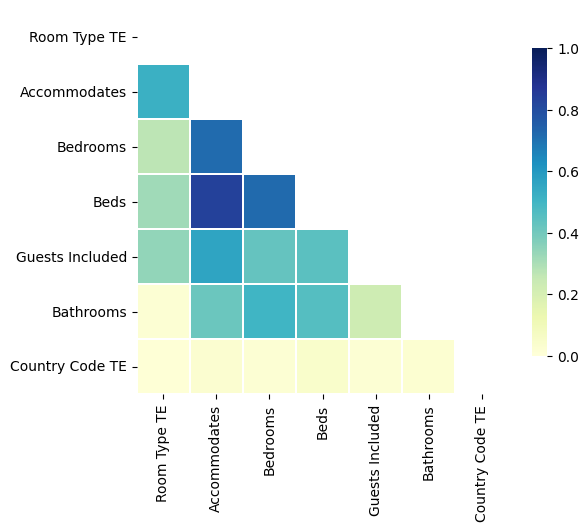

In [48]:
# Compute the correlation matrix
corr = np.abs(df_train_imp[features_sel].corr())
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6, 5))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

A correlation exists among features Accommodates, Beds, and Bedrooms. We keep feature Beds, which demonstrates the least correlation with the remaining variables.

In [49]:
features_sel = ['Room Type TE', 'Beds', 'Guests Included', 'Bathrooms', 'Country Code TE']

In [50]:
# TODO Correlations Amenities vs features